In [1]:
%cd ~/protein-transfer

/home/francesca/protein-transfer


In [2]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

In [3]:
from __future__ import annotations

import ast

import numpy as np
import pandas as pd

from scr.params.emb import MODEL_SIZE
from scr.params.vis import ORDERED_TASK_LIST, TASK_LEGEND_MAP

In [13]:
TRANSFORMER_INFO = {
    "esm1_t6_43M_UR50S": (768, 6, 2),
    "esm1_t12_85M_UR50S": (768, 12, 2),
    "esm1_t34_670M_UR50S": (1280, 34, 2),
    "esm1b_t33_650M_UR50S": (1280, 33, 2),
}

# encoder_name: (d_model, n_layers)
CARP_INFO = {
    "carp_600k": (128, 16),
    "carp_38M": (1024, 16),
    "carp_76M": (1024, 32),
    "carp_640M": (1280, 56),
}

In [14]:
MODEL_LAYER = {}
for info_dict in [TRANSFORMER_INFO, CARP_INFO]:
    for (model_name, model_dets) in info_dict.items():
        MODEL_LAYER[model_name] = model_dets[1]

MODEL_LAYER

{'esm1_t6_43M_UR50S': 6,
 'esm1_t12_85M_UR50S': 12,
 'esm1_t34_670M_UR50S': 34,
 'esm1b_t33_650M_UR50S': 33,
 'carp_600k': 16,
 'carp_38M': 16,
 'carp_76M': 32,
 'carp_640M': 56}

In [30]:
MODEL_LAYER = {
    model_name: model_dets[1]
    for info_dict in [TRANSFORMER_INFO, CARP_INFO, {"onehot": (1, 1)}]
    for model_name, model_dets in info_dict.items()
}

MODEL_LAYER

{'esm1_t6_43M_UR50S': 6,
 'esm1_t12_85M_UR50S': 12,
 'esm1_t34_670M_UR50S': 34,
 'esm1b_t33_650M_UR50S': 33,
 'carp_600k': 16,
 'carp_38M': 16,
 'carp_76M': 32,
 'carp_640M': 56,
 'onehot': 1}

In [7]:
ORDERED_TASK_LIST, TASK_LEGEND_MAP

(['proeng_gb1_sampled',
  'proeng_gb1_low_vs_high',
  'proeng_gb1_two_vs_rest',
  'proeng_aav_two_vs_many',
  'proeng_aav_one_vs_many',
  'proeng_thermo_mixed_split',
  'annotation_scl_balanced',
  'structure_ss3_casp12',
  'structure_ss3_cb513',
  'structure_ss3_ts115'],
 {'proeng_gb1_sampled': 'GB1 - sampled',
  'proeng_gb1_low_vs_high': 'GB1 - low vs high',
  'proeng_gb1_two_vs_rest': 'GB1 - two vs rest',
  'proeng_aav_two_vs_many': 'AAV - two vs many',
  'proeng_aav_one_vs_many': 'AAV - one vs many',
  'proeng_thermo_mixed_split': 'Thermostability',
  'annotation_scl_balanced': 'Subcellular localization',
  'structure_ss3_casp12': 'SS3 - CASP12',
  'structure_ss3_cb513': 'SS3 - CB513',
  'structure_ss3_ts115': 'SS3 - TS115'})

In [4]:
# the highest performing layer - one-hot performance vs its rand - one-hot or stat - one-hot

In [4]:
result_df_path = "results/summary/all_results.csv"

result_df = pd.read_csv(result_df_path)

# check column name existance
for c in ["metric", "ablation", "arch", "value", "task", "model", "ptp"]:
    assert c in result_df.columns, f"{c} not in df from {result_df_path}"

# Convert the string of lists to NumPy arrays
result_df["value"] = result_df["value"].apply(ast.literal_eval).apply(np.array)

# make ptp float
result_df["ptp"] = result_df["ptp"].astype(float)

result_df

,arch,task,model,ablation,ptp,metric,value
0,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,train_loss,"[9.59526940116963, 6.894266263718891, 6.377686..."
1,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,val_loss,"[11.18654191999164, 8.622644328345816, 8.33617..."
2,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,test_loss,"[13.582533778622887, 53.712009437112215, 74.04..."
3,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,test_performance_1,"[0.9704321391244177, 0.9629028051372428, 0.962..."
4,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,test_performance_2,"[0.19544242309285326, 0.3282696048440418, 0.31..."
...,...,...,...,...,...,...,...
1629,esm,annotation_scl_balanced,onehot,onehot,0.0,train_loss,[0.3524752729817441]
1630,esm,annotation_scl_balanced,onehot,onehot,0.0,val_loss,[1.373852210385459]
1631,esm,annotation_scl_balanced,onehot,onehot,0.0,test_loss,[2.0159953236579895]
1632,esm,annotation_scl_balanced,onehot,onehot,0.0,test_performance_2,[0.37402597402597404]


In [31]:
prepped_df = result_df.copy()

# add task type and model size details for plotting legends
prepped_df["task_type"] = prepped_df["task"].str.split("_").str[0]
prepped_df["model_size"] = prepped_df["model"].map(MODEL_SIZE)
prepped_df["model_layer"] = prepped_df["model"].map(MODEL_LAYER)

# get rid of pooling details
prepped_df["task"] = prepped_df["task"].str.replace("_mean", "")
prepped_df["task"] = prepped_df["task"].str.replace("_noflatten", "")

# sort based on given task order for plot legend
prepped_df["task"] = pd.Categorical(
    prepped_df["task"], categories=ORDERED_TASK_LIST, ordered=True
).map(TASK_LEGEND_MAP)
prepped_df = prepped_df.sort_values(["task", "ptp"], ascending=[True, False])

prepped_df

,arch,task,model,ablation,ptp,metric,value,task_type,model_size,model_layer
80,carp,GB1 - sampled,carp_640M,emb,1.0,train_loss,"[2.5043217133381526, 1.8768573377906583, 1.809...",proeng,640.00,56
81,carp,GB1 - sampled,carp_640M,emb,1.0,val_loss,"[2.4487856676276403, 1.889322691593076, 1.8535...",proeng,640.00,56
82,carp,GB1 - sampled,carp_640M,emb,1.0,test_loss,"[2.5326230877883487, 1.9205839668776579, 1.879...",proeng,640.00,56
83,carp,GB1 - sampled,carp_640M,emb,1.0,test_performance_1,"[0.8536247926960799, 0.9469106827092577, 0.949...",proeng,640.00,56
84,carp,GB1 - sampled,carp_640M,emb,1.0,test_performance_2,"[0.433213705534327, 0.8222689931610957, 0.8221...",proeng,640.00,56
...,...,...,...,...,...,...,...,...,...,...
1586,esm,NaN,esm1_t6_43M_UR50S,stat,0.0,val_loss,"[0.9926145014009977, 0.9802829968301874, 0.972...",structure,43.00,6
1593,esm,NaN,esm1b_t33_650M_UR50S,stat,0.0,train_loss,"[0.9954574287754215, 0.976576955351111, 0.9950...",structure,650.00,33
1594,esm,NaN,esm1b_t33_650M_UR50S,stat,0.0,val_loss,"[0.9926900832276595, 0.9727039494012532, 0.995...",structure,650.00,33
1621,esm,NaN,onehot,onehot,0.0,train_loss,[1.0096537658613023],structure,0.02,1


In [149]:
prepped_df.metric.unique()

array(['train_loss', 'val_loss', 'test_loss', 'test_performance_1',
       'test_performance_2'], dtype=object)

In [150]:
from scr.params.sys import DEFAULT_SPLIT

METRIC_TYPE = ["loss", "performance_1", "performance_2"] 

SIMPLE_METRIC_LIST = [f"{s}_{t}" for s in DEFAULT_SPLIT for t in METRIC_TYPE]


In [151]:
SIMPLE_METRIC_LIST

['train_loss',
 'train_performance_1',
 'train_performance_2',
 'val_loss',
 'val_performance_1',
 'val_performance_2',
 'test_loss',
 'test_performance_1',
 'test_performance_2']

In [32]:

# Count the number of rows with NaN values to make sure just structure_ss3_tape_processed - should be 76
prepped_df.isna().any(axis=1).sum()

76

In [33]:
def get_best_metric_df(
    df: pd.DataFrame, metric: str = "test_performance_1"
) -> pd.DataFrame:

    """
    A function for cleaning up the df to get best layer based on chosen metric
    """

    slice_df = df[(df["metric"] == metric)].copy()

    slice_df = slice_df[
        (slice_df["ablation"] == "onehot") | (slice_df["ablation"] == "emb")
    ]

    # get the max perform layer
    slice_df["best_value"] = slice_df["value"].apply(np.max)
    slice_df["best_layer"] = slice_df["value"].apply(np.argmax)

    # Find the index of the maximum value in 'value_column' for each group
    max_indices = slice_df.groupby(["task", "ablation"])["best_value"].idxmax().dropna()

    # Use loc to select the rows corresponding to the max indices
    slice_df = slice_df.loc[max_indices]

    return slice_df.copy()

In [98]:
metric = "test_performance_1"

In [34]:
slice_df = get_best_metric_df(prepped_df, metric)
slice_df

,arch,task,model,ablation,ptp,metric,value,task_type,model_size,model_layer,best_value,best_layer
1143,esm,GB1 - sampled,esm1b_t33_650M_UR50S,emb,1.000,test_performance_1,"[0.8745456721944233, 0.9569111956879088, 0.975...",proeng,650.00,33,0.982116,19
383,carp,GB1 - sampled,onehot,onehot,0.000,test_performance_1,[0.9342600571731149],proeng,0.02,1,0.934260,0
1118,esm,GB1 - low vs high,esm1b_t33_650M_UR50S,emb,1.000,test_performance_1,"[0.903277878702286, 0.9335615212571972, 0.9457...",proeng,650.00,33,0.957389,28
373,carp,GB1 - low vs high,onehot,onehot,0.000,test_performance_1,[0.9178409557926928],proeng,0.02,1,0.917841,0
1103,esm,GB1 - two vs rest,esm1b_t33_650M_UR50S,emb,1.000,test_performance_1,"[0.8657585156979741, 0.8857919692347899, 0.883...",proeng,650.00,33,0.915935,33
378,carp,GB1 - two vs rest,onehot,onehot,0.000,test_performance_1,[0.8905737288756033],proeng,0.02,1,0.890574,0
38,carp,AAV - two vs many,carp_640M,emb,1.000,test_performance_1,"[0.9725606587824112, 0.9747175045406921, 0.979...",proeng,640.00,56,0.986344,47
368,carp,AAV - two vs many,onehot,onehot,0.000,test_performance_1,[0.9629290404042454],proeng,0.02,1,0.962929,0
1173,esm,AAV - one vs many,esm1_t34_670M_UR50S,emb,1.000,test_performance_1,"[0.9749284643621607, 0.9631804832458407, 0.968...",proeng,670.00,34,0.974928,0
363,carp,AAV - one vs many,onehot,onehot,0.000,test_performance_1,[0.960145115831988],proeng,0.02,1,0.960145,0


In [40]:
emb_df = slice_df[slice_df["ablation"] == "emb"].copy()
emb_df["model_layer_percent"] = emb_df["best_layer"] / emb_df["model_layer"] * 100
emb_df

,arch,task,model,ablation,ptp,metric,value,task_type,model_size,model_layer,best_value,best_layer,model_layer_percent
1143,esm,GB1 - sampled,esm1b_t33_650M_UR50S,emb,1.000,test_performance_1,"[0.8745456721944233, 0.9569111956879088, 0.975...",proeng,650.0,33,0.982116,19,57.575758
1118,esm,GB1 - low vs high,esm1b_t33_650M_UR50S,emb,1.000,test_performance_1,"[0.903277878702286, 0.9335615212571972, 0.9457...",proeng,650.0,33,0.957389,28,84.848485
1103,esm,GB1 - two vs rest,esm1b_t33_650M_UR50S,emb,1.000,test_performance_1,"[0.8657585156979741, 0.8857919692347899, 0.883...",proeng,650.0,33,0.915935,33,100.000000
38,carp,AAV - two vs many,carp_640M,emb,1.000,test_performance_1,"[0.9725606587824112, 0.9747175045406921, 0.979...",proeng,640.0,56,0.986344,47,83.928571
1173,esm,AAV - one vs many,esm1_t34_670M_UR50S,emb,1.000,test_performance_1,"[0.9749284643621607, 0.9631804832458407, 0.968...",proeng,670.0,34,0.974928,0,0.000000
738,carp,Thermostability,carp_640M,emb,0.125,test_performance_1,"[0.9813129847231125, 0.9871396364773508, 0.987...",proeng,640.0,56,0.991915,19,33.928571
1511,esm,Subcellular localization,esm1_t34_670M_UR50S,emb,1.000,test_performance_1,"[0.6989621845468805, 0.7242104481886018, 0.738...",annotation,670.0,34,0.889651,30,88.235294
781,carp,SS3 - CASP12,carp_640M,emb,1.000,test_performance_1,"[0.569651794124983, 0.7229113201758404, 0.7781...",structure,640.0,56,0.861787,50,89.285714
783,carp,SS3 - CB513,carp_640M,emb,1.000,test_performance_1,"[0.58521902044986, 0.7732639939715383, 0.83207...",structure,640.0,56,0.940782,50,89.285714
785,carp,SS3 - TS115,carp_640M,emb,1.000,test_performance_1,"[0.5886661643179971, 0.7782446158099438, 0.842...",structure,640.0,56,0.943047,50,89.285714


In [135]:
def get_value(
    df: pd.DataFrame, row_to_match: dict, ablation: str, layer_numb: int
) -> float:

    """
    A function to get value of a given layer and other specifics
    """

    row_to_match["ablation"] = ablation

    # Create a boolean mask for each condition
    conditions = [df[col] == value for col, value in row_to_match.items()]

    # Combine the conditions with AND (use np.all)
    mask = np.all(conditions, axis=0)

    # Use the mask to select the matching row(s)
    matching_rows = df[mask]

    assert len(matching_rows) == 1, f"{matching_rows} len not 1!"

    return matching_rows["value"].to_numpy()[0][int(layer_numb)]

In [138]:
# col to add
statorrand = ["stat", "rand"]

for ab in statorrand:
    emb_df[ab] = np.nan
    emb_df[f"{ab} - onehot"] = np.nan

emb_df["emb - onehot"] = np.nan

emb_df = emb_df.reset_index(drop=True)

# get the corresponding stat and rand value at the layer
for i, row in emb_df.iterrows():

    # Convert the row to a dictionary
    row_dict = row.to_dict()

    # Select certain keys from the dictionary
    selected_keys = ["arch", "task", "metric", "model"]

    # pick the row to match
    row_to_match = {key: row_dict[key] for key in selected_keys}

    # get the onehot baseline
    onehot_val = get_value(
            df=prepped_df,
            row_to_match={key: row_dict[key] if i < 3 else "onehot" for i, key in enumerate(selected_keys)},
            ablation="onehot",
            layer_numb=0,
        )
    
    # calc best emb perf del
    emb_df.at[i, "emb - onehot"] = emb_df.at[i, "best_value"] - onehot_val

    for ab in statorrand:

        statorrand_val = get_value(
            df=prepped_df,
            row_to_match=row_to_match,
            ablation=ab,
            layer_numb=row_dict["best_layer"],
        )

        emb_df.at[i, ab] = statorrand_val
        emb_df.at[i, f"{ab} - onehot"] = statorrand_val - onehot_val


In [139]:
emb_df

,arch,task,model,ablation,ptp,metric,value,task_type,model_size,model_layer,best_value,best_layer,model_layer_percent,stat,rand,stat - onehot,rand - onehot,emb - onehot
0,esm,GB1 - sampled,esm1b_t33_650M_UR50S,emb,1.000,test_performance_1,"[0.8745456721944233, 0.9569111956879088, 0.975...",proeng,650.0,33,0.982116,19,57.575758,0.954639,0.938625,0.020379,0.004365,0.047856
1,esm,GB1 - low vs high,esm1b_t33_650M_UR50S,emb,1.000,test_performance_1,"[0.903277878702286, 0.9335615212571972, 0.9457...",proeng,650.0,33,0.957389,28,84.848485,0.929613,0.919844,0.011772,0.002003,0.039548
2,esm,GB1 - two vs rest,esm1b_t33_650M_UR50S,emb,1.000,test_performance_1,"[0.8657585156979741, 0.8857919692347899, 0.883...",proeng,650.0,33,0.915935,33,100.000000,0.879758,0.886252,-0.010815,-0.004322,0.025361
3,carp,AAV - two vs many,carp_640M,emb,1.000,test_performance_1,"[0.9725606587824112, 0.9747175045406921, 0.979...",proeng,640.0,56,0.986344,47,83.928571,0.985416,0.978499,0.022487,0.015570,0.023414
4,esm,AAV - one vs many,esm1_t34_670M_UR50S,emb,1.000,test_performance_1,"[0.9749284643621607, 0.9631804832458407, 0.968...",proeng,670.0,34,0.974928,0,0.000000,0.974928,0.974928,0.014783,0.014783,0.014783
5,carp,Thermostability,carp_640M,emb,0.125,test_performance_1,"[0.9813129847231125, 0.9871396364773508, 0.987...",proeng,640.0,56,0.991915,19,33.928571,0.984065,0.985005,0.028603,0.029543,0.036453
6,esm,Subcellular localization,esm1_t34_670M_UR50S,emb,1.000,test_performance_1,"[0.6989621845468805, 0.7242104481886018, 0.738...",annotation,670.0,34,0.889651,30,88.235294,0.888530,0.887692,0.226624,0.225786,0.227745
7,carp,SS3 - CASP12,carp_640M,emb,1.000,test_performance_1,"[0.569651794124983, 0.7229113201758404, 0.7781...",structure,640.0,56,0.861787,50,89.285714,0.585095,0.660694,-0.035118,0.040481,0.241574
8,carp,SS3 - CB513,carp_640M,emb,1.000,test_performance_1,"[0.58521902044986, 0.7732639939715383, 0.83207...",structure,640.0,56,0.940782,50,89.285714,0.592778,0.696579,-0.047741,0.056060,0.300263
9,carp,SS3 - TS115,carp_640M,emb,1.000,test_performance_1,"[0.5886661643179971, 0.7782446158099438, 0.842...",structure,640.0,56,0.943047,50,89.285714,0.605540,0.708398,-0.036432,0.066426,0.301076


In [100]:
import math
import matplotlib.pyplot as plt

from scr.params.vis import (
    ORDERED_TASK_LIST,
    TASK_LEGEND_MAP,
    TASK_COLORS,
    TASK_SIMPLE_COLOR_MAP,
    PLOT_EXTS,
)

Plotting Best test_performance_1 embedding against random init ablation...


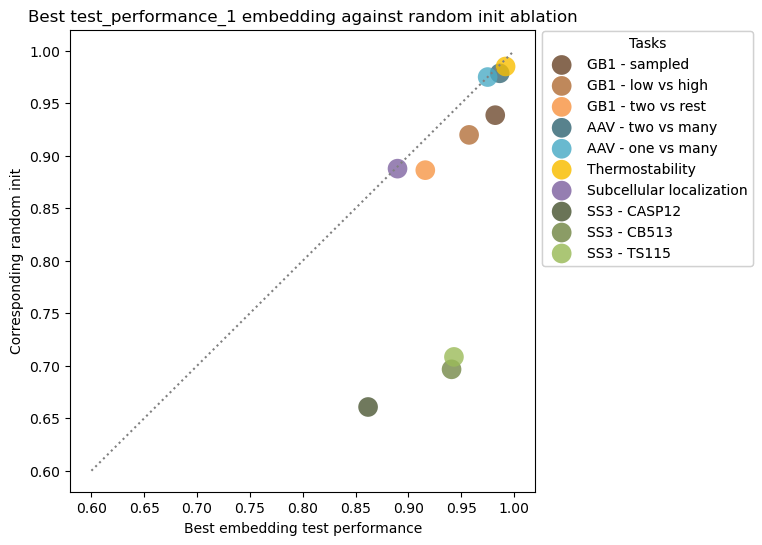

In [109]:
plot_title = f"Best {metric} embedding against random init ablation"

print(f"Plotting {plot_title}...")

fig, ax = plt.subplots()
fig.set_size_inches(6, 6)

# get the min x or y for the diagnol line
diag_min = 1

for (task, c) in TASK_SIMPLE_COLOR_MAP.items():

    task_df = emb_df[emb_df["task"] == task]

    y = task_df["rand"].values
    # note their is only one onehot for all embeddings for each tast
    x = task_df["best_value"].values
    # x = np.repeat(x, len(y))

    min_xy = min(min(y), min(x))
    if min_xy < diag_min:
        diag_min = min_xy

    c = c

    scatter = ax.scatter(x, y, c=c, s=200, alpha=0.8, label=task, edgecolors="none")

# diag min to smallest one decimal
diag_min = math.floor(diag_min * 10) / 10

# Add a diagonal line
plt.plot(
    [diag_min, 1],
    [diag_min, 1],
    linestyle=":",
    color="grey",
)

legend1 = ax.legend(title="Tasks", bbox_to_anchor=(1, 1.012), loc="upper left")
ax.add_artist(legend1)

plt.xlabel("Best embedding test performance")
plt.ylabel("Corresponding random init")
plt.title(plot_title)

plt.show()

Plotting Best test_performance_1 embedding against random init ablation...


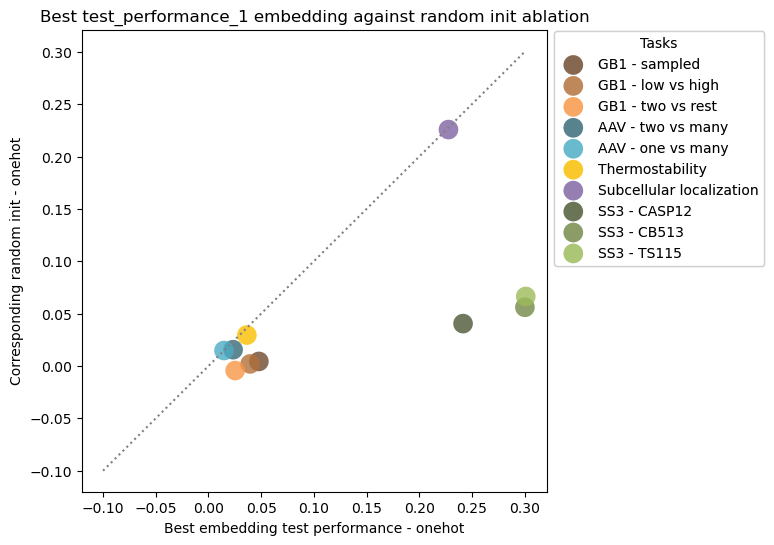

In [145]:
plot_title = f"Best {metric} embedding against random init ablation"

print(f"Plotting {plot_title}...")

fig, ax = plt.subplots()
fig.set_size_inches(6, 6)

# get the min x or y for the diagnol line
diag_min = 1
diag_max = 0

for (task, c) in TASK_SIMPLE_COLOR_MAP.items():

    task_df = emb_df[emb_df["task"] == task]

    y = task_df["rand - onehot"].values
    # note their is only one onehot for all embeddings for each tast
    x = task_df["emb - onehot"].values
    # x = np.repeat(x, len(y))

    min_xy = min(min(y), min(x))
    max_xy = max(max(x), max(y))

    if min_xy < diag_min:
        diag_min = min_xy
    
    if max_xy > diag_max:
        diag_max = max_xy

    c = c

    scatter = ax.scatter(x, y, c=c, s=200, alpha=0.8, label=task, edgecolors="none")

# diag min to smallest one decimal
diag_min = math.floor(diag_min * 10) / 10

# Add a diagonal line
plt.plot(
    [diag_min, diag_max],
    [diag_min, diag_max],
    linestyle=":",
    color="grey",
)

legend1 = ax.legend(title="Tasks", bbox_to_anchor=(1, 1.012), loc="upper left")
ax.add_artist(legend1)

plt.xlabel("Best embedding test performance - onehot")
plt.ylabel("Corresponding random init - onehot")
plt.title(plot_title)

plt.show()

Plotting Best test_performance_1 embedding against stat transfer ablation...


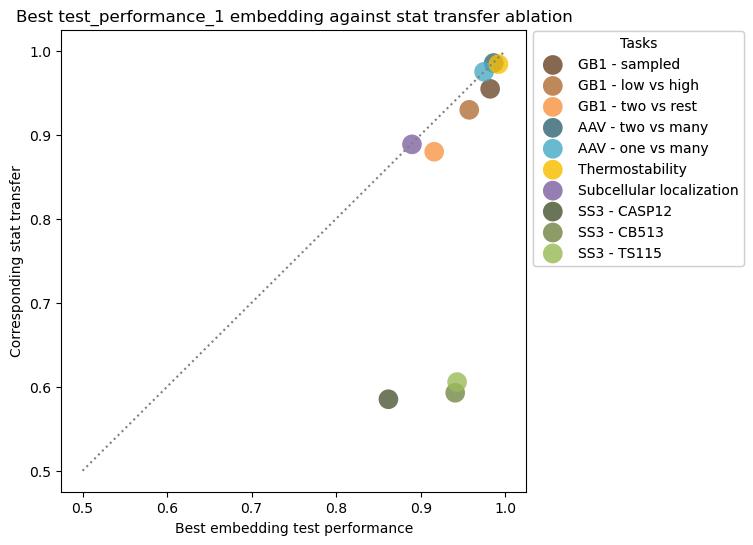

In [143]:
plot_title = f"Best {metric} embedding against stat transfer ablation"

print(f"Plotting {plot_title}...")

fig, ax = plt.subplots()
fig.set_size_inches(6, 6)

# get the min x or y for the diagnol line
diag_min = 1

for (task, c) in TASK_SIMPLE_COLOR_MAP.items():

    task_df = emb_df[emb_df["task"] == task]

    y = task_df["stat"].values
    # note their is only one onehot for all embeddings for each tast
    x = task_df["best_value"].values
    # x = np.repeat(x, len(y))

    min_xy = min(min(y), min(x))

    if min_xy < diag_min:
        diag_min = min_xy
    
    c = c

    scatter = ax.scatter(x, y, c=c, s=200, alpha=0.8, label=task, edgecolors="none")

# diag min to smallest one decimal
diag_min = math.floor(diag_min * 10) / 10

# Add a diagonal line
plt.plot(
    [diag_min, 1],
    [diag_min, 1],
    linestyle=":",
    color="grey",
)

legend1 = ax.legend(title="Tasks", bbox_to_anchor=(1, 1.012), loc="upper left")
ax.add_artist(legend1)

plt.xlabel("Best embedding test performance")
plt.ylabel("Corresponding stat transfer")
plt.title(plot_title)

plt.show()

Plotting Best test_performance_1 embedding against stat transfer ablation...


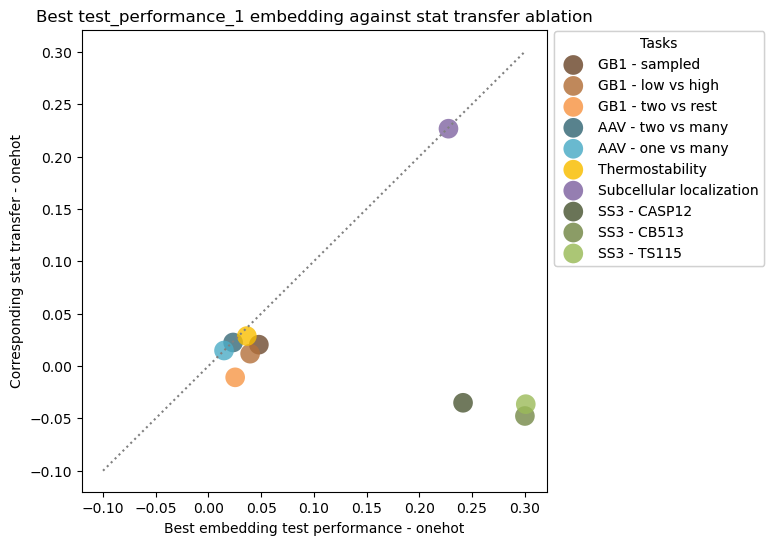

In [147]:
plot_title = f"Best {metric} embedding against stat transfer ablation"

print(f"Plotting {plot_title}...")

fig, ax = plt.subplots()
fig.set_size_inches(6, 6)

# get the min x or y for the diagnol line
diag_min = 1
diag_max = 0

for (task, c) in TASK_SIMPLE_COLOR_MAP.items():

    task_df = emb_df[emb_df["task"] == task]

    y = task_df["stat - onehot"].values
    # note their is only one onehot for all embeddings for each tast
    x = task_df["emb - onehot"].values
    # x = np.repeat(x, len(y))

    min_xy = min(min(y), min(x))
    max_xy = max(max(x), max(y))

    if min_xy < diag_min:
        diag_min = min_xy
    
    if max_xy > diag_max:
        diag_max = max_xy

    c = c

    scatter = ax.scatter(x, y, c=c, s=200, alpha=0.8, label=task, edgecolors="none")

# diag min to smallest one decimal
diag_min = math.floor(diag_min * 10) / 10

# Add a diagonal line
plt.plot(
    [diag_min, diag_max],
    [diag_min, diag_max],
    linestyle=":",
    color="grey",
)

legend1 = ax.legend(title="Tasks", bbox_to_anchor=(1, 1.012), loc="upper left")
ax.add_artist(legend1)

plt.xlabel("Best embedding test performance - onehot")
plt.ylabel("Corresponding stat transfer - onehot")
plt.title(plot_title)

plt.show()

In [42]:
import matplotlib.pyplot as plt
from scr.params.vis import (
    ORDERED_TASK_LIST,
    TASK_LEGEND_MAP,
    TASK_COLORS,
    TASK_SIMPLE_COLOR_MAP,
    PLOT_EXTS,
)

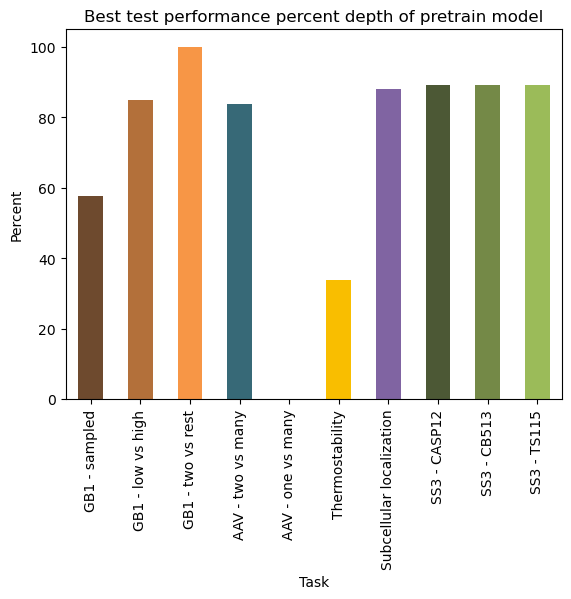

In [47]:
# Create a bar plot with custom colors
fig, ax = plt.subplots()
emb_df.plot(
    kind="bar",
    x="task",
    y="model_layer_percent",
    color=[TASK_SIMPLE_COLOR_MAP.get(task, "gray") for task in emb_df["task"]],
    ax=ax,
    legend=None,
)

# Set labels and title
plt.xlabel("Task")
plt.ylabel("Percent")
plt.title("Best test performance percent depth of pretrain model")

# Show the plot
plt.show()

In [6]:

result_df["value"] = result_df["value"].apply(np.max)
result_df


,arch,task,model,ablation,ptp,metric,value
0,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,train_loss,9.595269
1,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,val_loss,11.186542
2,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,test_loss,142.187723
3,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,test_performance_1,0.970432
4,carp,proeng_aav_one_vs_many_mean,carp_640M,emb,1.0,test_performance_2,0.452518
...,...,...,...,...,...,...,...
1629,esm,annotation_scl_balanced,onehot,onehot,0.0,train_loss,0.352475
1630,esm,annotation_scl_balanced,onehot,onehot,0.0,val_loss,1.373852
1631,esm,annotation_scl_balanced,onehot,onehot,0.0,test_loss,2.015995
1632,esm,annotation_scl_balanced,onehot,onehot,0.0,test_performance_2,0.374026


In [7]:
result_df["ablation"].unique()

array(['emb', 'rand', 'stat', 'onehot'], dtype=object)

In [8]:
# MODEL_SIZE need to include onehot
# will be max seq * # token

In [9]:
df_perf_1 = result_df[
    (result_df["metric"] == "test_performance_1") & (result_df["arch"] == "esm")
].copy()
df_perf_1["task_type"] = df_perf_1["task"].str.split("_").str[0]
df_perf_1["model_size"] = df_perf_1["model"].map(MODEL_SIZE)

df_perf_1

,arch,task,model,ablation,ptp,metric,value,task_type,model_size
1078,esm,proeng_thermo_mixed_split_mean,esm1_t34_670M_UR50S,emb,1.0,test_performance_1,0.991052,proeng,670.00
1083,esm,proeng_thermo_mixed_split_mean,esm1_t12_85M_UR50S,emb,1.0,test_performance_1,0.990692,proeng,85.00
1088,esm,proeng_thermo_mixed_split_mean,esm1b_t33_650M_UR50S,emb,1.0,test_performance_1,0.991452,proeng,650.00
1093,esm,proeng_thermo_mixed_split_mean,esm1_t6_43M_UR50S,emb,1.0,test_performance_1,0.990299,proeng,43.00
1098,esm,proeng_gb1_two_vs_rest_mean,esm1_t6_43M_UR50S,emb,1.0,test_performance_1,0.895943,proeng,43.00
...,...,...,...,...,...,...,...,...,...
1620,esm,annotation_scl_balanced_mean,esm1b_t33_650M_UR50S,stat,0.0,test_performance_1,0.889467,annotation,650.00
1624,esm,structure_ss3_casp12,onehot,onehot,0.0,test_performance_1,0.620213,structure,0.02
1626,esm,structure_ss3_cb513,onehot,onehot,0.0,test_performance_1,0.640519,structure,0.02
1628,esm,structure_ss3_ts115,onehot,onehot,0.0,test_performance_1,0.641972,structure,0.02


In [10]:
df_perf_1["task"] = df_perf_1["task"].str.replace("_mean", "")
df_perf_1["task"] = df_perf_1["task"].str.replace("_noflatten", "")

# df_perf_1["task"] = df_perf_1["task"].str.replace({"_mean": "", "_noflatten": ""})



In [11]:
df_perf_1["task"] = pd.Categorical(df_perf_1["task"], categories=ORDERED_TASK_LIST, ordered=True).map(TASK_LEGEND_MAP)
df_perf_1 = df_perf_1.sort_values("task")

df_perf_1

,arch,task,model,ablation,ptp,metric,value,task_type,model_size
1148,esm,GB1 - sampled,esm1_t12_85M_UR50S,emb,1.0,test_performance_1,0.971845,proeng,85.00
1388,esm,GB1 - sampled,esm1_t12_85M_UR50S,stat,0.0,test_performance_1,0.953893,proeng,85.00
1153,esm,GB1 - sampled,esm1_t6_43M_UR50S,emb,1.0,test_performance_1,0.973137,proeng,43.00
1143,esm,GB1 - sampled,esm1b_t33_650M_UR50S,emb,1.0,test_performance_1,0.982116,proeng,650.00
1138,esm,GB1 - sampled,esm1_t34_670M_UR50S,emb,1.0,test_performance_1,0.977456,proeng,670.00
...,...,...,...,...,...,...,...,...,...
1472,esm,SS3 - TS115,esm1_t34_670M_UR50S,emb,1.0,test_performance_1,0.932380,structure,670.00
1628,esm,SS3 - TS115,onehot,onehot,0.0,test_performance_1,0.641972,structure,0.02
1524,esm,SS3 - TS115,esm1_t34_670M_UR50S,rand,0.0,test_performance_1,0.721797,structure,670.00
1576,esm,SS3 - TS115,esm1_t34_670M_UR50S,stat,0.0,test_performance_1,0.708840,structure,670.00


In [12]:
import numpy as np
import scipy.special
import pandas as pd

# Our main plotting package (must have explicit import of submodules)
import bokeh.io
import bokeh.plotting

# Enable viewing Bokeh plots in the notebook
bokeh.io.output_notebook()

Loading BokehJS ...

In [13]:
df_perf_1.ablation.unique()

array(['emb', 'stat', 'rand', 'onehot'], dtype=object)

In [14]:
df_perf_1 = df_perf_1[(df_perf_1["ablation"] == "onehot") | (df_perf_1["ablation"] == "emb")]
df_perf_1

,arch,task,model,ablation,ptp,metric,value,task_type,model_size
1148,esm,GB1 - sampled,esm1_t12_85M_UR50S,emb,1.0,test_performance_1,0.971845,proeng,85.00
1153,esm,GB1 - sampled,esm1_t6_43M_UR50S,emb,1.0,test_performance_1,0.973137,proeng,43.00
1143,esm,GB1 - sampled,esm1b_t33_650M_UR50S,emb,1.0,test_performance_1,0.982116,proeng,650.00
1138,esm,GB1 - sampled,esm1_t34_670M_UR50S,emb,1.0,test_performance_1,0.977456,proeng,670.00
1453,esm,GB1 - sampled,onehot,onehot,0.0,test_performance_1,0.934260,proeng,0.02
1448,esm,GB1 - low vs high,onehot,onehot,0.0,test_performance_1,0.917841,proeng,0.02
1133,esm,GB1 - low vs high,esm1_t6_43M_UR50S,emb,1.0,test_performance_1,0.943977,proeng,43.00
1128,esm,GB1 - low vs high,esm1_t34_670M_UR50S,emb,1.0,test_performance_1,0.947277,proeng,670.00
1123,esm,GB1 - low vs high,esm1_t12_85M_UR50S,emb,1.0,test_performance_1,0.942702,proeng,85.00
1118,esm,GB1 - low vs high,esm1b_t33_650M_UR50S,emb,1.0,test_performance_1,0.957389,proeng,650.00


In [15]:
df_perf_1.task.unique()

['GB1 - sampled', 'GB1 - low vs high', 'GB1 - two vs rest', 'AAV - two vs many', 'AAV - one vs many', 'Thermostability', 'Subcellular localization', 'SS3 - CASP12', 'SS3 - CB513', 'SS3 - TS115']
Categories (10, object): ['GB1 - sampled' < 'GB1 - low vs high' < 'GB1 - two vs rest' < 'AAV - two vs many' ... 'Subcellular localization' < 'SS3 - CASP12' < 'SS3 - CB513' < 'SS3 - TS115']

In [16]:
from bokeh.palettes import brewer


In [17]:
import seaborn as sns

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline  

In [19]:
from scr.params.vis import ORDERED_TASK_LIST, ORDERED_TASK_LIST_SIMPLE, TASK_LEGEND_MAP, TASK_SIMPLE_COLOR_MAP

In [20]:
from scr.params.emb import MODEL_SIZE

In [21]:
import matplotlib as mpl

In [22]:
TASK_SIMPLE_COLOR_MAP

{'GB1 - sampled': '#6e4a2e',
 'GB1 - low vs high': '#b3703a',
 'GB1 - two vs rest': '#f79646',
 'AAV - two vs many': '#376977',
 'AAV - one vs many': '#4bacc6',
 'Thermostability': '#f9be00',
 'Subcellular localization': '#8064a2',
 'SS3 - CASP12': '#4c5835',
 'SS3 - CB513': '#748947',
 'SS3 - TS115': '#9bbb59'}

In [26]:
# split into 1) just best emb and 2) different emb best layer 
result_df = pd.read_csv("results/summary/all_results.csv")

# Convert the string of lists to NumPy arrays
result_df["value"] = result_df["value"].apply(ast.literal_eval).apply(np.array)

result_df["value"] = result_df["value"].apply(np.max)

df_perf_1 = result_df[
    (result_df["metric"] == "test_performance_1") & (result_df["arch"] == "esm")
].copy()
df_perf_1["task_type"] = df_perf_1["task"].str.split("_").str[0]
df_perf_1["model_size"] = df_perf_1["model"].map(MODEL_SIZE)

df_perf_1["task"] = df_perf_1["task"].str.replace("_mean", "")
df_perf_1["task"] = df_perf_1["task"].str.replace("_noflatten", "")

# df_perf_1["task"] = df_perf_1["task"].str.replace({"_mean": "", "_noflatten": ""})

df_perf_1["task"] = pd.Categorical(df_perf_1["task"], categories=ORDERED_TASK_LIST, ordered=True).map(TASK_LEGEND_MAP)
df_perf_1 = df_perf_1.sort_values("task")

df_perf_1 = df_perf_1[(df_perf_1["ablation"] == "onehot") | (df_perf_1["ablation"] == "emb")]
df_perf_1

,arch,task,model,ablation,ptp,metric,value,task_type,model_size
1148,esm,GB1 - sampled,esm1_t12_85M_UR50S,emb,1.0,test_performance_1,0.971845,proeng,85.00
1153,esm,GB1 - sampled,esm1_t6_43M_UR50S,emb,1.0,test_performance_1,0.973137,proeng,43.00
1143,esm,GB1 - sampled,esm1b_t33_650M_UR50S,emb,1.0,test_performance_1,0.982116,proeng,650.00
1138,esm,GB1 - sampled,esm1_t34_670M_UR50S,emb,1.0,test_performance_1,0.977456,proeng,670.00
1453,esm,GB1 - sampled,onehot,onehot,0.0,test_performance_1,0.934260,proeng,0.02
1448,esm,GB1 - low vs high,onehot,onehot,0.0,test_performance_1,0.917841,proeng,0.02
1133,esm,GB1 - low vs high,esm1_t6_43M_UR50S,emb,1.0,test_performance_1,0.943977,proeng,43.00
1128,esm,GB1 - low vs high,esm1_t34_670M_UR50S,emb,1.0,test_performance_1,0.947277,proeng,670.00
1123,esm,GB1 - low vs high,esm1_t12_85M_UR50S,emb,1.0,test_performance_1,0.942702,proeng,85.00
1118,esm,GB1 - low vs high,esm1b_t33_650M_UR50S,emb,1.0,test_performance_1,0.957389,proeng,650.00


In [35]:
df_perf_1.groupby(["task", "ptp", "ablation"])["value"].idxmax().dropna()

task                      ptp  ablation
GB1 - sampled             0.0  onehot      1453.0
                          1.0  emb         1143.0
GB1 - low vs high         0.0  onehot      1448.0
                          1.0  emb         1118.0
GB1 - two vs rest         0.0  onehot      1443.0
                          1.0  emb         1103.0
AAV - two vs many         0.0  onehot      1463.0
                          1.0  emb         1193.0
AAV - one vs many         0.0  onehot      1458.0
                          1.0  emb         1173.0
Thermostability           0.0  onehot      1438.0
                          1.0  emb         1088.0
Subcellular localization  0.0  onehot      1633.0
                          1.0  emb         1511.0
SS3 - CASP12              0.0  onehot      1624.0
                          1.0  emb         1492.0
SS3 - CB513               0.0  onehot      1626.0
                          1.0  emb         1494.0
SS3 - TS115               0.0  onehot      1628.0
          

In [36]:
# Find the index of the maximum value in 'value_column' for each group
max_indices = df_perf_1.groupby(["task", "ptp", "ablation"])["value"].idxmax().dropna()

# Use loc to select the rows corresponding to the max indices
df_perf_1_max_emb = df_perf_1.loc[max_indices]

In [37]:
df_perf_1_max_emb

,arch,task,model,ablation,ptp,metric,value,task_type,model_size
1453,esm,GB1 - sampled,onehot,onehot,0.0,test_performance_1,0.934260,proeng,0.02
1143,esm,GB1 - sampled,esm1b_t33_650M_UR50S,emb,1.0,test_performance_1,0.982116,proeng,650.00
1448,esm,GB1 - low vs high,onehot,onehot,0.0,test_performance_1,0.917841,proeng,0.02
1118,esm,GB1 - low vs high,esm1b_t33_650M_UR50S,emb,1.0,test_performance_1,0.957389,proeng,650.00
1443,esm,GB1 - two vs rest,onehot,onehot,0.0,test_performance_1,0.890574,proeng,0.02
1103,esm,GB1 - two vs rest,esm1b_t33_650M_UR50S,emb,1.0,test_performance_1,0.915935,proeng,650.00
1463,esm,AAV - two vs many,onehot,onehot,0.0,test_performance_1,0.962929,proeng,0.02
1193,esm,AAV - two vs many,esm1b_t33_650M_UR50S,emb,1.0,test_performance_1,0.985687,proeng,650.00
1458,esm,AAV - one vs many,onehot,onehot,0.0,test_performance_1,0.960145,proeng,0.02
1173,esm,AAV - one vs many,esm1_t34_670M_UR50S,emb,1.0,test_performance_1,0.974928,proeng,670.00


In [29]:
model_sizes

array([8.5e+01, 4.3e+01, 6.5e+02, 6.7e+02, 2.0e-02])

0 0.8 None


TypeError: 'module' object is not callable

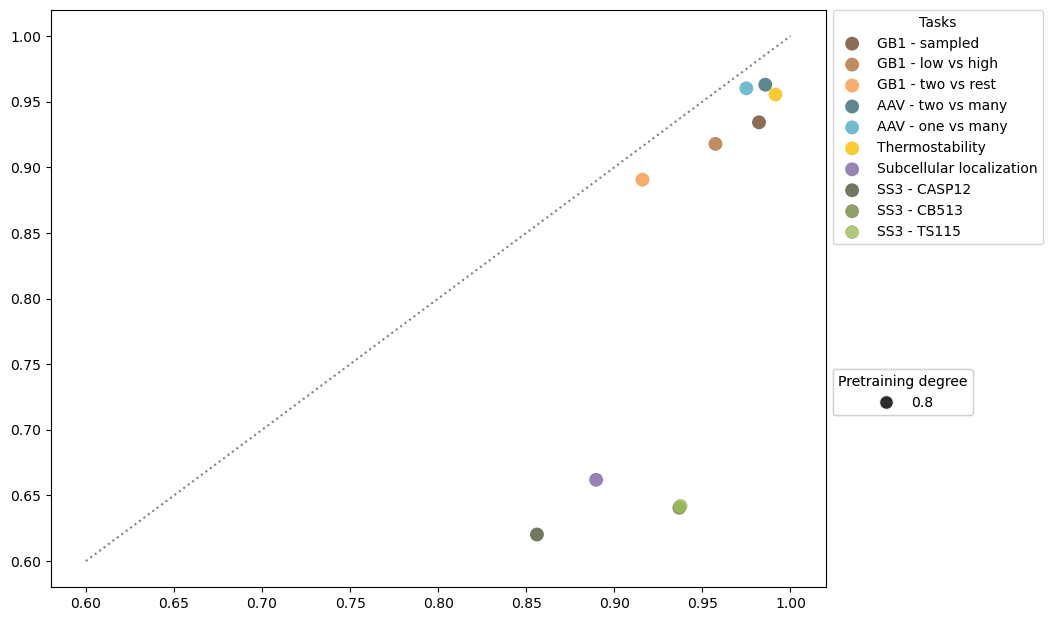

In [30]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
import numpy as np

fig, ax = plt.subplots()
fig.set_size_inches(10, 7.5)

for (task, c) in TASK_SIMPLE_COLOR_MAP.items():
    sliced_df = df_perf_1_max_emb[df_perf_1_max_emb["task"] == task]
    emb_df = sliced_df[sliced_df["ablation"] == "emb"]
    onehot_df = sliced_df[sliced_df["ablation"] == "onehot"]

    x = emb_df["value"].values
    # note their is only one onehot for all embeddings for each tast
    y = onehot_df["value"].values
    y = np.repeat(y, len(x))

    c = c
    # the there is one for onehot
    model_sizes = sliced_df["model_size"].values

    # s = np.log(model_sizes[~np.isnan(model_sizes)]) * 18
    alpha = [0.8]
    scatter = ax.scatter(x, y, c=c, 
                         s=100,
                         # s=s, 
                         label=task, alpha=alpha, edgecolors="none")

# Add a diagonal line
plt.plot([0.6, 1], [0.6, 1], linestyle=":", color="grey", # label='Diagonal Line'
         )

legend1 = ax.legend(title="Tasks", bbox_to_anchor=(1, 1.012), loc="upper left")
ax.add_artist(legend1)

"""handles, labels = scatter.legend_elements(prop="sizes", color="k", alpha=0.8)
legend2 = ax.legend(
    handles, list(MODEL_SIZE.keys())[:4], bbox_to_anchor=(1, 0.5925), loc="upper left", title="Model sizes"
)
ax.add_artist(legend2)"""

alpha_legend = [None] * len(alpha)
for i, a in enumerate(alpha):
    print(i, str(a), alpha_legend[i])
    alpha_legend[i] = Line2D([0], [0], marker='o', color='w', label=str(a), alpha=a, markerfacecolor='k', markersize=10)

ax.add_artist(ax.legend(handles=alpha_legend, bbox_to_anchor=(1, 0.39), loc="upper left", title="Pretraining degree"))

mpl.legend(alignment='left')

plt.xlabel("Best embedding performance")
plt.ylabel("Onehot")
plt.title("ESM best layer test performance against onehot baseline")

plt.show()

In [39]:
import math 

math.floor(0.58 * 10) / 10

0.5